# 43008: Reinforcement Learning

## Week 7: Temporal-Difference Methods: Control
## Part C: Q-Learning

This notebook will explore the implementation of a Temporal-Difference (TD) method, Q-Learning, on the CliffWalking and Taxi environment.

* Q-Learning Algorithm for Gym based environments

### What you will learn?
* Implement Q-Learning Algorithm
* Use Q-Learning on Cliffwalking and Taxi Environments

## 1. Imports and Utilities




In [1]:
!pip install gymnasium pyvirtualdisplay
!apt-get install -y xvfb ffmpeg

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
!pip install gymnasium[other]
!pip install gymnasium[toy-text]

In [18]:
import sys
import os
import gymnasium as gym
import numpy as np
import random
import glob
import io
import base64
from collections import namedtuple
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

### Utility Functions




#### Plot Values

In [5]:
# Function to plot the Episode statistics
# Adapted from: https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py

def plot_episode_stats(stats, smoothing_window=10, noshow=False):

    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [6]:
# Plot State Values
def plot_values(V, shape):
    # Reshape the value function V to the given shape
    V = np.reshape(V, shape)

    # Create a new figure with a specific size
    fig = plt.figure(figsize=(15,5))

    # Add a subplot to the figure. 111 means 1x1 grid, first subplot.
    ax = fig.add_subplot(111)

    # Display the reshaped value function V as an image on the axes
    im = ax.imshow(V, cmap='cool')

    # For each value in V, annotate the plot with the value's rounded label
    for (j,i),label in np.ndenumerate(V):
        ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)

    # Disable ticks and tick labels for both x and y axes
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')

    # Set the title for the plot
    plt.title('State-Value Function')

    # Display the plot
    plt.show()


#### Simulate and show video

In [7]:
def simulate_and_show_video(env_id, Q, epsilon):
    """
    Simulate an environment using a given policy and display the video.

    Parameters:
    - env_id: The string ID of the environment to simulate.
    - Q: The action-value function (Q-table).
    - epsilon: The epsilon value for the epsilon-greedy policy.


    Returns:
    - HTML object if video was captured, or a message indicating no videos were found.
    """
    video_folder = f"./{env_id}_videos"

    # Create the environment with the specified render_mode and wrap it
    # The RecordVideo wrapper handles the video creation.
    env = gym.make(env_id, render_mode='rgb_array')
    env = RecordVideo(env, video_folder=video_folder)

    state, info = env.reset()
    done = False

    while not done:
        action = epsilon_greedy_policy(Q, state, epsilon) # Use epsilon_greedy_policy to select action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    # Close the environment, which finalizes the video recording.
    env.close()

    # Look for the '.mp4' files in the correct directory
    mp4list = glob.glob(f'{video_folder}/*.mp4')

    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)

        # Clean up the directory after displaying the video
        for file in mp4list:
            os.remove(file)
        os.rmdir(video_folder)

        return HTML(data=f'''<video alt="test" autoplay loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                      </video>''')
    else:
        return "No videos found or error during video creation."

## 2. TD Control Algorithms



### 2.1 Helper function:

#### Epsilon Greedy Action Selection

In [8]:
def epsilon_greedy_policy(Q, state, epsilon):
    """
    Select an action using epsilon-greedy policy.

    Parameters:
    - Q 2D np array: A 2S array that maps state to action values.
                For example, Q[state] = [0.1, 0.2, 0.4] for a 3-action environment.
    - state (int): Current state of the agent in the environment.

    - epsilon (float): The probability of choosing a random action (exploration factor).
                   It should be between 0 (no exploration) and 1 (only exploration).

    Returns:
    - action (int): The chosen action based on the epsilon-greedy policy.
    """
    # Generate a random number between 0 and 1. If it's less than epsilon,
    # then choose a random action, else the greedy action (the action with the maximum Q-value for the current state)
    if random.uniform(0,1) < epsilon:
        return env.action_space.sample()
    else:
        return max(list(range(env.action_space.n)), key = lambda x: Q[state, x])

#### Policy Extraction from Optimal-Q Values

In [9]:
def extract_policy_V_from_Q_flat(Q, env):
    """
    Extract flat policy and state-value function V from Q.

    Params:
    - Q: Action-value function.
    - env: The environment to extract policy and V for.

    Returns:
    - policy: Derived flat policy from Q.
    - V: Derived flat state-value function from Q.
    """

    n_states = env.observation_space.n
    policy = np.empty(n_states, dtype=np.int64)
    V = np.empty(n_states, dtype=np.float64)

    for state in range(n_states):
            policy[state] = np.argmax(Q[state, :])
            V[state] = np.max(Q[state, :])

    return policy, V

### 2.2 Q-Learning Algorithm



#### Pseudo-code for Q-Learning (off-policy TD control) from Sutton and Barto's book:




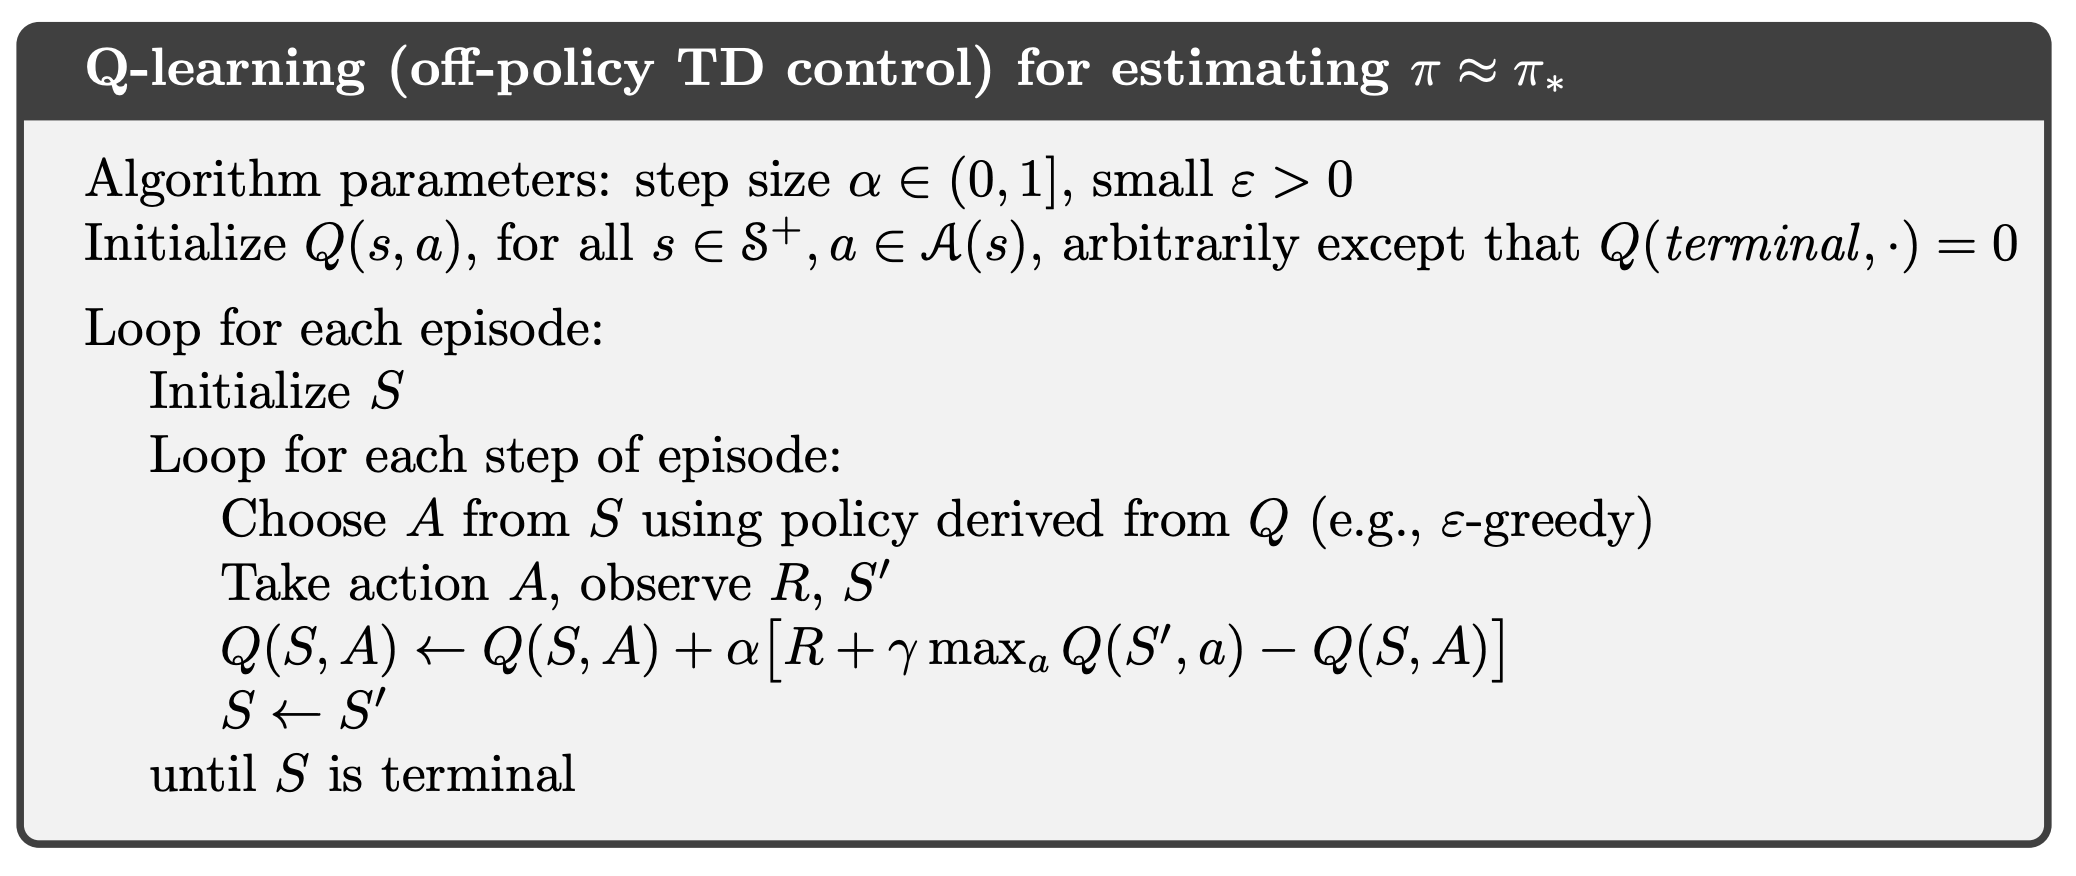

## Q-Learning Algorithm Code

In [11]:
def q_learning(env, num_episodes, gamma=1.0, alpha=0.85, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal epsilon-greedy policy.

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.

    Returns:
        Q is the optimal action-value function,
        stats is a named tuple, which returns the episode statistics for plotting
    """

    # Initialize Q values/Table to Zero
    Q = np.zeros((env.observation_space.n, env.action_space.n), dtype=float)

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # Run through several episodes
    for episode in range(num_episodes):

      # Store cumulative reward of each episodes in r
      r = 0

      # initialize the state,
      state, _ = env.reset()


      # Reset the Episodes time step, will be used for stats
      timeStep=0

      while True:

          # select the action using epsilon-greedy policy
          action = epsilon_greedy_policy(Q, state, epsilon)

          # then perform the action and move to the next state, and receive the reward
          nextstate, reward, terminated, truncated, info = env.step(action)
          done = terminated or truncated

          # Update statistics
          stats.episode_rewards[episode] += reward
          timeStep +=1
          stats.episode_lengths[episode] = timeStep

          # Calculate the Q-value of previous state using our update rule
          # Q[(state,action)] += alpha * (reward + gamma * Q[(nextstate,nextBestaction)]-Q[(state,action)])
          # Now, select the next BEST ACTION using epsilon greedy policy
          best_next_action = np.argmax(Q[nextstate,:])
          TD_target = reward + gamma * Q[nextstate, best_next_action]
          TD_error = TD_target - Q[state, action]

          Q[state, action] += alpha * TD_error

          # Update the state and BUT NOT action with next action and next state
          state = nextstate

          # store the rewards
          r += reward

          # Break the loop, if it is the terminal state of the episode
          if done:
              break

    print("Total Reward : ", r)
    return Q, stats

## 3. Running the Q-Learning Algorithms on different environments and Plotting Results



## CliffWalking Environment Exploration

The CliffWalking environment is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. The reward is -1 on all transitions except those into the region marked "The Cliff". Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start.



In [13]:
# Create an instance of the 'CliffWalking-v0' environment.
# 'CliffWalking' is a standard gridworld environment where the agent has to navigate from a start state to a goal state,
# avoiding falling off a cliff.
env = gym.make('CliffWalking-v1')

# Print the action space of the environment.
# This will show the number of possible actions an agent can take in the environment.
print(env.action_space)

# Print the observation space of the environment.
# This will show the number of possible states (or observations) an agent can encounter in the environment.
print(env.observation_space)

Discrete(4)
Discrete(48)


### Train the agent using Q-Learning

In [14]:
# Train agent using the Q-Learning algorithm
Q_table, stats = q_learning(env, 5000, gamma=1.0, alpha=0.5, epsilon=0.1)

Total Reward :  -13


### Extract policy and plot the value function

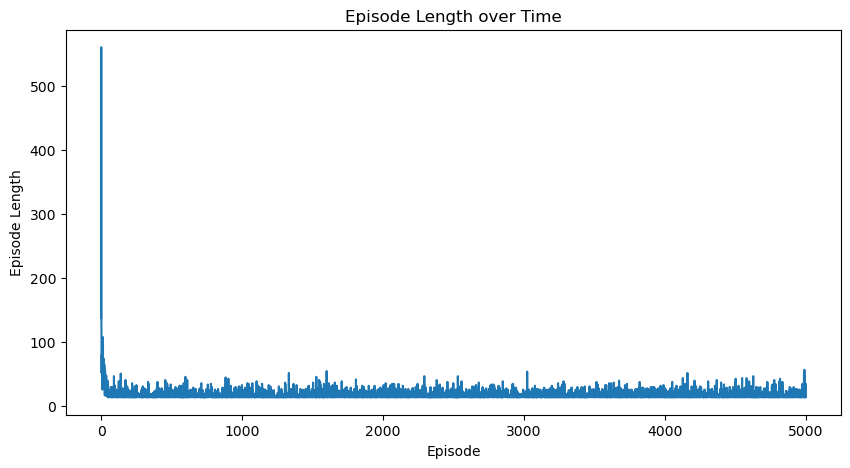

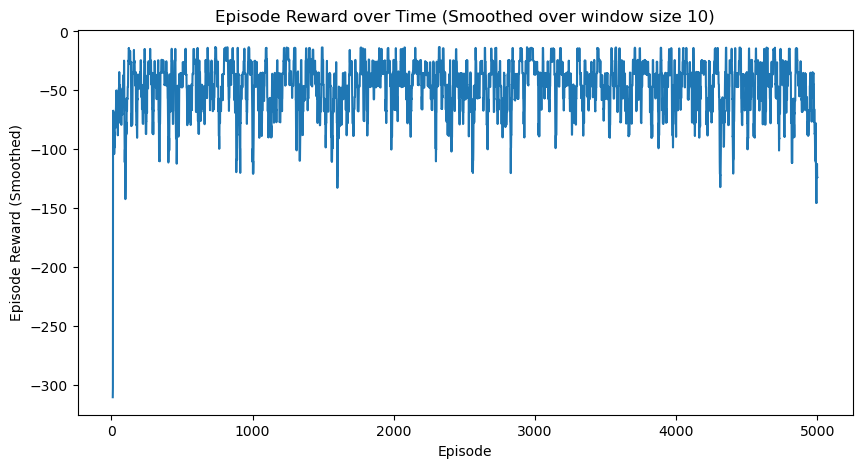

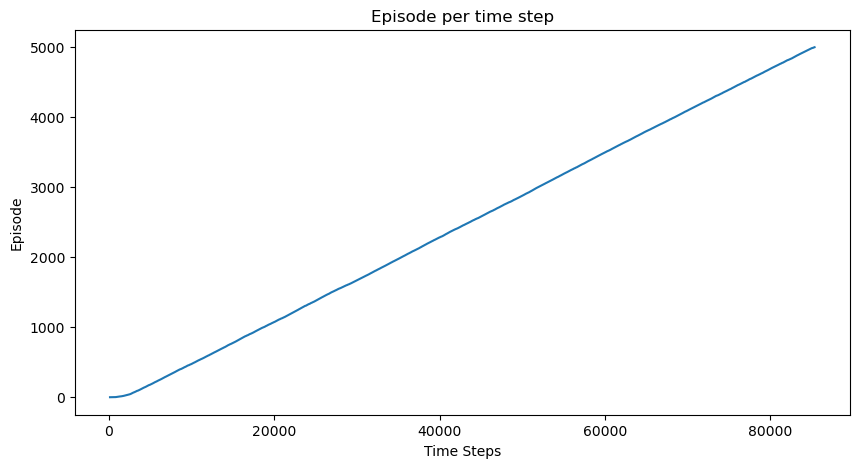

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [15]:
# The Episode Statistics
plot_episode_stats(stats)

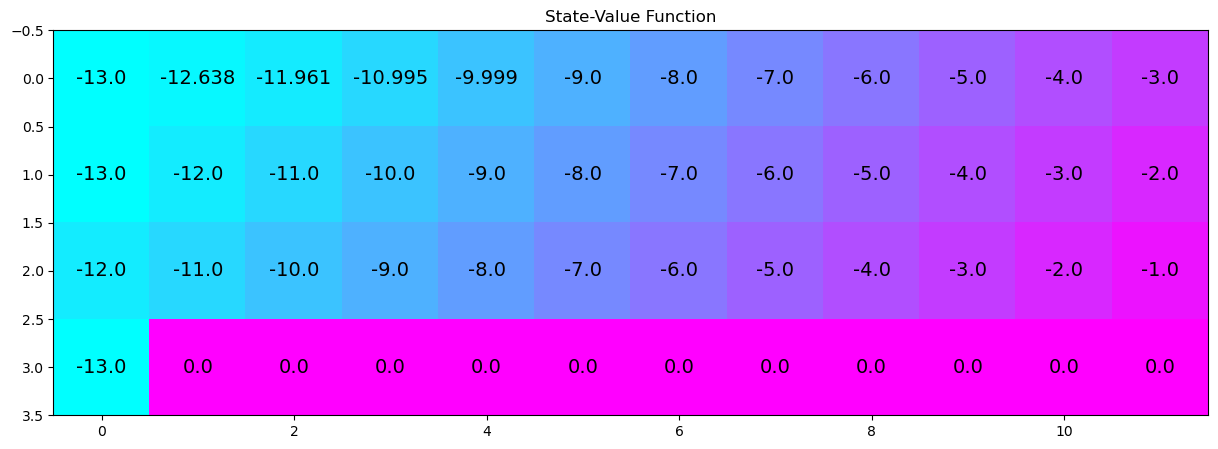

In [16]:
# Extract the optimal policy and corresponding state-value function (V)
# from the action-value function (Q_table) using the 'extract_policy_V_from_Q_flat' function.
# 'Q_table' is the action-value function derived from the Q-Learning algorithm.
policy_QL, V_QL = extract_policy_V_from_Q_flat(Q_table, env)

# Visualize the state-value function (V_table) using the 'plot_values' function.
# The state-value function is reshaped into a grid of size (4, 12) for visualization.
# In the context of the 'CliffWalking-v0' environment, the grid represents the layout of the environment
# with 4 rows and 12 columns.
plot_values(V_QL, (4, 12))


### Simulating the Optimal Policy

To visualize how the agent performs using the optimal policy derived from the Q-Learning algorithm, we'll simulate the environment and generate a video.

In [19]:
# Simulate the environment using the optimal policy suggested by Q-Learning and display the video
simulate_and_show_video('CliffWalking-v1', Q_table, epsilon=0.1)

/opt/conda/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /home/sagemaker-user/CliffWalking-v1_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


## Taxi Environment Exploration




In [20]:
# Create an instance of the 'Taxi-v3' environment.
# 'Taxi-v3' is a standard gridworld environment where the agent needs to pick up a passenger
# from a location and drop them off at another location, navigating through the grid.
env = gym.make('Taxi-v3')

# Print the action space of the environment.
# This will display the number of possible actions an agent can take in the environment.
print(env.action_space)

# Print the observation space of the environment.
# This will display the number of possible states (or observations) an agent can encounter in the environment.
print(env.observation_space)


Discrete(6)
Discrete(500)


### Train the agent using Q-Learning

In [21]:
# Train agent using the Q-Learning algorithm
Q_table, stats = q_learning(env, 5000, gamma=1.0, alpha=0.5, epsilon=0.1)

Total Reward :  -2


### Extract policy


In [22]:
# Using the 'extract_policy_V_from_Q_flat' function, extract the optimal policy (policy_QL)
# and the corresponding state-value function (V_QL) from the action-value function (Q_table)
# for the given environment (env).
# 'Q_table' is the action-value function derived from the Q-Learning algorithm.

policy_QL, V_QL = extract_policy_V_from_Q_flat(Q_table, env)

#### Note: We cannot plot the value function as taxi has 500 states, which do not relate to the grid. Each grid box can have approximately 20 different states as it is a 5x5 grid world.

In [24]:
# Simulate the environment using the optimal policy suggested by Q-Learning and display the video
simulate_and_show_video('Taxi-v3', Q_table, epsilon=0.1)

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


### Simulating the Optimal Policy

To visualize how the agent performs using the optimal policy derived from the Q-Learning algorithm, we'll simulate the environment and generate a video.

In [25]:
def simulate_and_show_video_with_policy(env_id, policy):
    """
    Simulate an environment using a given policy and display the video.

    Parameters:
    - env_id: The string ID of the environment to simulate.
    - policy: The policy to use for action selection.

    Returns:
    - HTML object if video was captured, or a message indicating no videos were found.
    """
    video_folder = f"./{env_id}_videos_policy" # Use a different folder name to avoid conflicts

    # Create the environment with the specified render_mode and wrap it
    # The RecordVideo wrapper handles the video creation.
    env = gym.make(env_id, render_mode='rgb_array')
    env = RecordVideo(env, video_folder=video_folder)

    state, info = env.reset()
    done = False

    while not done:
        action = policy[state] # Use the policy to select action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    # Close the environment, which finalizes the video recording.
    env.close()

    # Look for the '.mp4' files in the correct directory
    mp4list = glob.glob(f'{video_folder}/*.mp4')

    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)

        # Clean up the directory after displaying the video
        for file in mp4list:
            os.remove(file)
        os.rmdir(video_folder)


        return HTML(data=f'''<video alt="test" autoplay loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                      </video>''')
    else:
        return "No videos found or error during video creation."

In [26]:
# Simulate the environment using the optimal policy derived from Q-Learning and display the video
simulate_and_show_video_with_policy('Taxi-v3', policy_QL)

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
